In [10]:
import os

os.chdir(os.path.join(os.getcwd(),'..'))
os.getcwd()

'/media/user/T7 Touch/Stage_Lucas'

In [2]:
from src.nets import UNet
from src.downloads import download_data, unzip_data
from src.datasets import Cell_Challenge_Segmentation_Dataset, Embed_Segmentation_Dataset
from src.training import train_UNet, EarlyStopping
from src.segmentation import post_processing
from src.visualization import plot_mini_batch

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as alb

#### Datasets and Dataloaders options

In [3]:
batch_size = 1

Cell_train = Embed_Segmentation_Dataset(None)
Train, Val = random_split(Cell_train, [0.5, 0.5])

train_loader = DataLoader(Train, batch_size, shuffle=True)
val_loader = DataLoader(Val, batch_size, shuffle=True)

Test = Embed_Segmentation_Dataset(None, test=True)  # test mode

test_loader = DataLoader(Test, batch_size, shuffle=False)

#### Model's parameters

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(1, 64, 2)
EPOCHS = 100
STORE = 1
OPTIM = torch.optim.SGD(model.parameters(),
                                 lr=0.005, momentum=0.95,
                                 weight_decay=1e-4)

STOPPER = EarlyStopping(10)

SCHEDUL = torch.optim.lr_scheduler.OneCycleLR(OPTIM, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

cuda


#### Training and loss plots

In [5]:
from src.nets import kernel_3

In [9]:
device = torch.device('cpu')

for x, y in train_loader:
    model = model.to(device=device)
    x = x.to(device=device, dtype=torch.float32)
    y = y.to(device=device, dtype=torch.long).squeeze(1)
    pred = model(x)

In [10]:
pred.shape

torch.Size([1, 2, 512, 256])

In [11]:
train_loss, val_loss = train_UNet(model, device, OPTIM, train_loader, val_loader, STOPPER, None, EPOCHS)

Epoch: 1/100, Train loss: 0.8429, Val loss: 0.7102, Train acc: 0.2817, Val acc: 0.1773, Dice: 0.3012, IoU: 0.1773
Epoch: 2/100, Train loss: 0.6865, Val loss: 0.6923, Train acc: 0.8034, Val acc: 0.2332, Dice: 0.3782, IoU: 0.2332
Epoch: 3/100, Train loss: 0.4963, Val loss: 0.6467, Train acc: 0.9312, Val acc: 0.2254, Dice: 0.3679, IoU: 0.2254
Epoch: 4/100, Train loss: 0.5291, Val loss: 0.6049, Train acc: 0.8016, Val acc: 0.8428, Dice: 0.7327, IoU: 0.5781
Epoch: 5/100, Train loss: 0.4560, Val loss: 0.5896, Train acc: 0.9018, Val acc: 0.9574, Dice: 0.913, IoU: 0.84
Epoch: 6/100, Train loss: 0.3619, Val loss: 0.5190, Train acc: 0.9067, Val acc: 0.9422, Dice: 0.8704, IoU: 0.7706
Epoch: 7/100, Train loss: 0.3744, Val loss: 0.4346, Train acc: 0.8534, Val acc: 0.9541, Dice: 0.8978, IoU: 0.8145
Epoch: 8/100, Train loss: 0.2819, Val loss: 0.3883, Train acc: 0.9281, Val acc: 0.9574, Dice: 0.9016, IoU: 0.8209
Epoch: 9/100, Train loss: 0.3094, Val loss: 0.3265, Train acc: 0.9312, Val acc: 0.9606, Dic

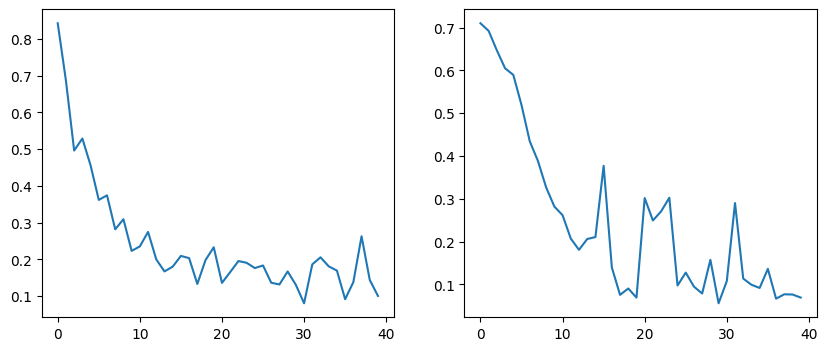

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

In [13]:
torch.save(model.state_dict(), f'{os.getcwd()}/src/models/unet_model_skull.pth')
model_trained = UNet(1, 64, 2)
model_trained.load_state_dict(torch.load(f'{os.getcwd()}/src/models/unet_model_skull.pth'))
model = model_trained

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Test predictions

In [15]:
Test[0][0].shape

torch.Size([1, 512, 256])

In [18]:
device = torch.device('cpu')

final_imgs = torch.zeros((len(Test), 512, 256))
final_pred = torch.zeros((len(Test), 512, 256))
model = model.to(device)
model.eval()
for i,data in enumerate(test_loader):
    imgs_test, _ = data
    imgs_test = imgs_test.to(device, dtype=torch.float32)

    with torch.no_grad():
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

    for j in range(len(preds)):
        final_imgs[i*batch_size+j,:,:] = imgs_test[j]
        final_pred[i*batch_size+j,:,:] = preds[j]

final_imgs = final_imgs.cpu()
final_pred = final_pred.cpu()

In [19]:
last = post_processing(final_pred, binary=False)

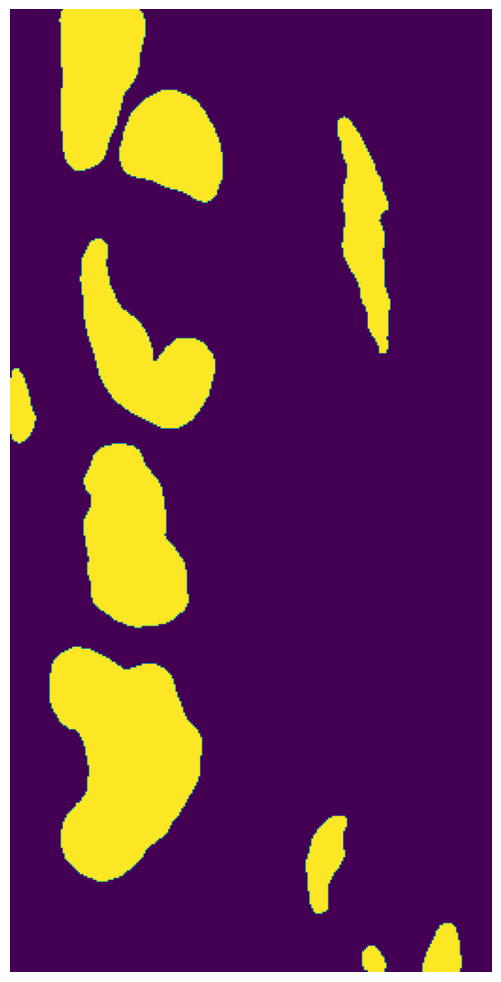

In [20]:
plot_mini_batch(final_pred[:4])

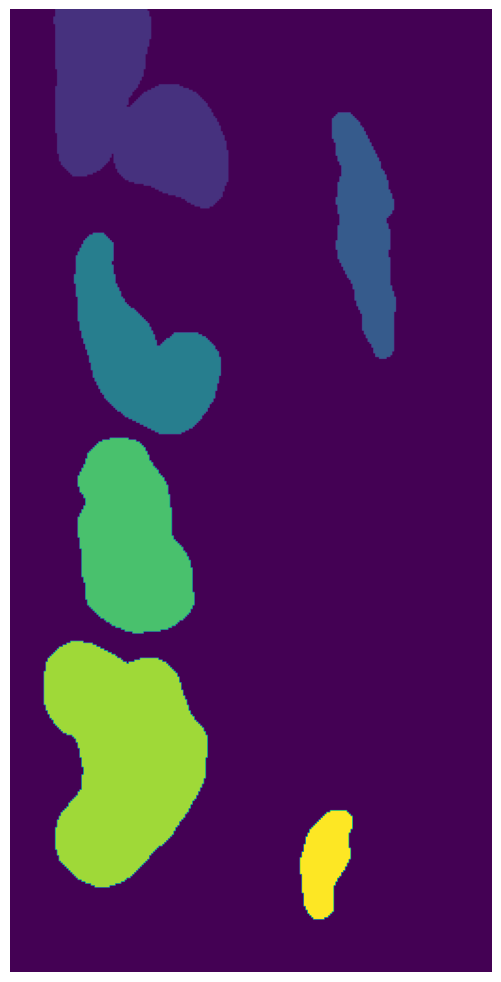

In [23]:
plot_mini_batch(last[:4])

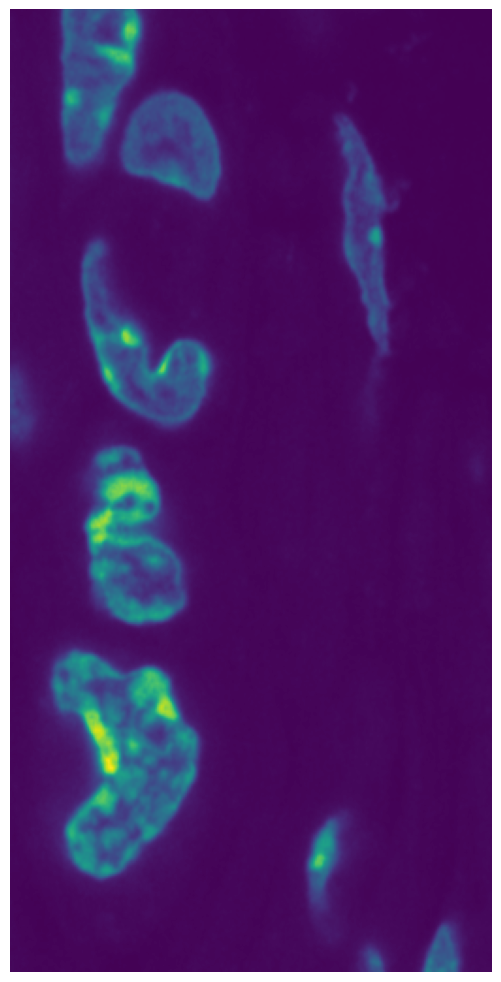

In [24]:
plot_mini_batch(final_imgs[:4])